this is for ipyhton only

In [239]:
%matplotlib inline

Lets first import some stuff

In [240]:
from numpy import *
#from scitools.easyviz.matplotlib_ import *
from matplotlib import *
import matplotlib.pyplot as plt
from math import log as ln

In [241]:
from IPython import get_ipython
ipython = get_ipython()

This defines the location of a file that holds all the atomic data we need. the files holds values fro the calculation of the sputter yield according to Sigmund as weel as Matsunami1984 and Yamamura1996. The latter two modify the calculation in a way that makes it more suitable for litgh ions aka He and Ne.

In [242]:
SRIM_ATOM_DATA_FILE="ATOMDATA"
SRIM_FILE="He-30kV-SRIM-sputter-yield.dat"
SRIM_Ne_FILE="Ne-30kV-SRIM-sputter-yield.dat"
NA=6.022e23

Lets define what we want to calculate
==========

Projectile
----------

In [243]:
Projectile="Ne"

Target
------

In [244]:
Target="Ga"

Energy
------

In [245]:
Energy=25000

Surface binding energy
-----
Use this to fix the surface displacment energy to a fixed value, which is not in the database. If this is set to -1 the tabulated value will be used in all other cases User_SBW will be used instead of the tabulated value.

In [246]:
User_SBE=2.0

Which Sputter model should we use
----
can be either _Sigmund_, _M84_ or _Y96_

In [247]:
sputter="M84"

Reduced nuclear stopping cross section
-----
We support two model namely Thomas Fermi (_TF_) or Krypton Carbon (_KrC_)

In [248]:
model="TF"

Lets read in the data

In [249]:
'''
Reads part of the data in the  SRIM ATOMS file and puts it in a 
useful format
'''
File = open(SRIM_ATOM_DATA_FILE, "r")
File.readline(); File.readline() # Skip the first two lines
Atom_Name=[]
Atom_SBE=[]
Atom_Z=[]
Atom_M=[]
Atom_Q84=[]
Atom_Q96=[]
Atom_W=[]
Atom_s=[]
for Element in File:
    Props=Element.split()
    Atom_Name.append(Props[1])
    Atom_SBE.append(float(Props[6]))
    Atom_Z.append(int(Props[0]))
    Atom_M.append(float(Props[4]))
    Atom_Q84.append(float(Props[7]))
    Atom_Q96.append(float(Props[8]))
    Atom_W.append(float(Props[9]))
    Atom_s.append(float(Props[10]))
File.close
'''
We return the Name, Z, M and SBE in separate sublists
'''
Atoms=Atom_Name,Atom_Z,Atom_M,Atom_SBE,Atom_Q84,Atom_Q96,Atom_W,Atom_s

More data to read from SRIm simulations so for only for He 30kV

In [250]:
''' 
Reads SRIM sputter yield results from an additional file
data provided by nico
'''
File = open(SRIM_FILE, "r")
File.readline()
Z=[]
Y=[]

In [251]:
for Element in File:
    Data=Element.split(",")
    Z.append(int(Data[0]))
    Y.append(float(Data[1])/float(Data[2]))
File.close
Y_He_srim=Z,Y

In [252]:
File = open(SRIM_Ne_FILE, "r")
Z=[]
Y=[]

In [253]:
for Element in File:
    Data=Element.split(",")
    Z.append(int(Data[0]))
    Y.append(float(Data[1])/float(Data[2]))
File.close
Y_Ne_srim=Z,Y

Y_He_srim contains the results of a SRIM simulation of the sputter yield for 30 keV He into the elements. Y_Ne_srim the same data for Ne.

Let's get the values we need from the data files

All the different values will be computed in functions so we can call them at anytime, and reuse them for making graphs and similar stuff

Reduced Energy
---
The formula for the reduced energy is the same in Y96 and M84. The following is Equ 22 from Y96.
$$\epsilon=\frac{0.03255}{Z_1Z_2(Z_1^{2/3}+Z_2^{2/3})^{1/2}}\frac{M_2}{M_1+M_2}$$

For Sigmund I reimplement L. Bischoff's BASIC program he uses: $$\epsilon=\frac{0.069497M_2aE}{(M_1+M_2)Z_1Z_2}$$
where $a=0.469209/(Z_1^{2/3}+Z_2^{2/3})^{1/2}$

In [254]:
def reduced_energy(Projectile,Target,Energy,sputter_model):
    '''
    Uses equ. 2 from M84
    '''
    Z1=Atoms[1][Atoms[0].index(Projectile)]
    Z2=Atoms[1][Atoms[0].index(Target)]
    M1=Atoms[2][Atoms[0].index(Projectile)]
    M2=Atoms[2][Atoms[0].index(Target)]
    if sputter_model=="Sigmund":
        a=0.469209/((Z1**(2.0/3.0)+Z2**(2.0/3.0))**(1.0/2.0))
        return  (0.069497*M2*a*Energy)/((M1+M2)*Z1*Z2)
    else:
        # This will be used for Y96 and M84
        return 0.03255/(Z1*Z2*(Z1**(2./3)+Z2**(2./3))**0.5)*M2/(M1+M2)*Energy

Reduced nuclear stopping cross section $s_n$
----
Next comes the reduced nuclear stopping cross section. In M84 this is Linhards elastic reduced stopping cross section $$s_n(\epsilon)=\frac{3.441\sqrt{\epsilon}\ln(\epsilon+2.718)}{1+6.355\sqrt{\epsilon}+\epsilon(-1.708+6.882\sqrt{\epsilon})}$$ This Thomas Fermi based approach is also used for Sigmund sputtering.

In Y96 two different expresion for the reduced nuclear stopping power are suggested. ONe is based on the Thomas-Fermi potential and identical to the M84 experssion for $s-n(\epsilon)$. The other is based on the Kr-C and comes from Eckstein in the wollwoing paper: W. Eckstein, C. Garcia-Rosales, J. Roth, and W. Ot- tenberger, IPP 9/82 (Inst. Plasma Physics, Garching, Germany, 1993)
A new swithc is introduced that allows to use the KrC based equation in the calculation.$$s_n^{KrC}(\epsilon)=\frac{0.5ln(1+1.2288\epsilon)}{\epsilon+0.1728\sqrt{\epsilon}+0.008\epsilon^{0.1504}}$$

In [255]:
def reduced_nuc_stopping_x_section(Projectile,Target,Energy,sputter_model,model):
    '''
    based on equ. A1 
    calcultes reduced_energy(Projectile,Target,Energy)
    Depending on the last parameter 'model' we either use a Kr-C based stopping power (model=KrC) or in all other 
    cases a Thomas-Fermi based approach as used in M84
    '''
    # lets first calculate the reduced energy
    eps=reduced_energy(Projectile,Target,Energy,sputter_model)
    # we have two different models. If model is KrC we use the one introduced by Eckstein and mentioned in Y96 
    if model=="KrC":
        return 0.5*ln(1+1.2288*eps)/(eps+0.1728*sqrt(eps)+0.0088*eps**0.1504)
    # in all other cases we use the M84 Thomas-Fermi model
    else:
        # This is the Thomas Fermi as given in Y96 and M84 we also use this for Sigmund
        return 3.441*sqrt(eps)*ln(eps+2.718)/(1+6.355*sqrt(eps)+eps*(-1.708+6.882*sqrt(eps)))

Reduced electronic stopping cross section $s_e=k\sqrt{\epsilon}$
---
The next thing to calculate is the reduced electronic stopping cross section. In M84 this is given by $$s_e=k\sqrt{\epsilon}$$ where$$k=0.079\frac{(M_1+M_2)^{3/2}}{M_1^{3/2}M_2^{1/2}}\frac{Z_1^{3/2}Z_2^{1/2}}{(Z_1^{2/3}+Z_2^{2/3})^{3/4}}$$.
The updated model in Y96 uses the same experssion here.

In [256]:
def k(Projectile,Target):
    '''
    the same expression for k is used in both M84 and Y96.
    '''
    Z1=Atoms[1][Atoms[0].index(Projectile)]
    Z2=Atoms[1][Atoms[0].index(Target)]
    M1=Atoms[2][Atoms[0].index(Projectile)]
    M2=Atoms[2][Atoms[0].index(Target)]
    return 0.079*((M1+M2)**(3./2))/((M1**(3./2)*M2**(.5)))*((Z1**(2./3)*Z2**(.5))/((Z1**(2./3)+Z2**(2./3))**(3./4)))

In [257]:
def reduced_elec_stopping_x_section(Projectile,Target,Energy,sputter_model):
    ''' 
    based on equ A2 and A3
    calcultes reduced_energy(Projectile,Target,Energy) first
    '''
    return k(Projectile,Target)*sqrt(reduced_energy(Projectile,Target,Energy,sputter_model))

Nuclear stopping $S_n=Ks_n$
----
The conversion factor from the elastic reduced stopping corss section $s_n$ to the stopping cross secion $S_n$ $K$ is given by (3) in M84 $$K=\frac{S_n}{s_n}=8.478\frac{Z_1Z_2}{(Z_1^{2/3}+Z_2^{2/3})^{1/2}}\frac{M_1}{M_1+M_2}$$ this than has the unit $eV cm^{2}/10^{15} atoms$. from there we can calculate $S_n$.
In Y96 the equation is the same but different units are used ($eVA^2/atom$). As a result for Y96 the value is bigger by a factor 10. This has to be done as other empirical parameters are also in the new unit system.
We are not interested in $K$ but $S_n$ so we calculate that one directly from $s_nK$.

In [258]:
def Sn(Projectile,Target,Energy,sputter_model,nuc_x_section_model):
    '''
    Calculats Sn needs the model for the nuclear stopping to calculate the reduced stopping power
    '''
    Z1=Atoms[1][Atoms[0].index(Projectile)]
    Z2=Atoms[1][Atoms[0].index(Target)]
    M1=Atoms[2][Atoms[0].index(Projectile)]
    M2=Atoms[2][Atoms[0].index(Target)]
    if sputter_model=="Sigmund":
        a=0.469209/((Z1**(2.0/3.0)+Z2**(2.0/3.0))**(1.0/2.0))
        return (18.081264*Z1*Z2*M1*reduced_nuc_stopping_x_section(Projectile,Target,Energy,sputter_model,nuc_x_section_model)*a)/(M1+M2)
    else:
        # We end up here if we use either M84 or Y96
        # the first parameter is 84 in Y96 instead of 8 in M84 due to different units used. This is corrected by also changing the Y(E) from 0.042 (Y96) to 0.42 (M84)
        return 8.478*Z1*Z2/(Z1**(2./3)+Z2**(2./3))**0.5*M1/(M1+M2)*reduced_nuc_stopping_x_section(Projectile,Target,Energy,sputter_model,nuc_x_section_model)

Dimensionless parameter $\alpha^*$
---
An expression for $\alpha^*$ (one of the empirical parameters) is given in equ 4 of M84
$$\alpha^*(M_2/M_1)=0.08+0.164(\frac{M_2}{M_1})^{0.4}+0.0124(\frac{M_2}{M_1})^{1.29}$$

For Y96 the situation gets more complicated. Depending on the M1/M2 ratio we need to use two different expressions for $\alpha^*$ (see equ. 17 in Y96).
$$\alpha^*=0.249(M_2/M_1)^{0.56}+0.0035(M_2/M_1)^{1.5}, M1 \le M2$$ or
$$\alpha^*=0.0875(M_2/M_1)^{-0.15}+0.165(M_2/M_1), M1 \gt M2$$
From L. Bischoff we take $$\alpha=0.1694+0.4218\left(\frac{M_2}{M_1}\right)+0.0518\left(\frac{M_2}{M_1}\right)^2-0.00926\left(\frac{M_2}{M_1}\right)^3+0.00049\left(\frac{M_2}{M_1}\right)^4$$ for the Sigmund case.

In [259]:
def alpha_stern(Projectile,Target,sputter):
    '''
    based on equ 4
    '''
    M1=Atoms[2][Atoms[0].index(Projectile)]
    M2=Atoms[2][Atoms[0].index(Target)]
    if sputter == "M84":
        return 0.08+0.164*(M2/M1)**0.4+0.0145*(M2/M1)**(1.29)
    elif sputter == "Y96":
        if M1 <= M2:
            #M1 is smaller than M2 will be the case nearly all the time in our situation
            return 0.249*(M2/M1)**0.56+0.0035*(M2/M1)**1.5
        else:
            # obviously now M1 is larger than M2
            return 0.0875*(M2/M1)**-0.15+0.165*(M2/M1)
    else:
        # seems we need to do Sigmund
        X=M2/M1
        return 0.1694+(0.04218*X)+(0.0518*(X**2))-(0.00926*(X**3))+(0.00049*(X**4))

Empirical parameters
===

$E_{th}$
----

Sigmund used the binding energy with out further modification. We wuill use the tabulated values we have for $U_s$. In case of Y96 and M84 the situation is more complex.

Equation 5 in M84 gives $$E_{th}=U_s\left(1.9+3.8(M_2/M_1)^{-1}+0.134(M_2/M_1)^{1.24}\right)$$ one of the empirical parameters defined in M84. $U_s$ is the sublimation energie and tabullated for many targets.

Again for Y96 the situation gets more complex. we use equ 18 and 19 to solve.
$$E_{th}=U_s*\frac{6.7}{\gamma}, M_1 \gt M_2$$ or $$E_{th}=U_s*\frac{1+5.7(M_1/M_2)}{\gamma}, M1 \le M2 $$ with $$\gamma=\frac{4M_1M_2}{(M_1+M_2)^2}$$

In [260]:
def eth(Projectile,Target,sputter):
    '''
    based on equ. 5 but aslo needs tabulated values of Us
    '''
    if User_SBE==-1:
        Us=Atoms[3][Atoms[0].index(Target)]
    else:
        Us=User_SBE
    M1=Atoms[2][Atoms[0].index(Projectile)]
    M2=Atoms[2][Atoms[0].index(Target)]
    if sputter == "M84":
        return Us*(1.9+3.8*(M1/M2)+0.134*(M2/M1)**1.24)
    elif sputter == "Y96":
        gamma=4*M1*M2/(M1+M2)**2
        if M1 <= M2:
            return Us*(1.0+5.7*(M1/M2))/gamma
        else: 
            return Us*6.7/gamma
    else:
        #It seems we are using Sigmund. Nothing todo. But we return Us nevertheless
        return Us

$\Gamma$
---
The Y96 model requires one more parameter. $$\Gamma=\frac{W(Z_2)}{1+(M_1/7)^3}$$ requires also a tabulated parameter $W(Z_2)$ which has index 6 in the array.

In [261]:
def Gamma(Projectile,Target):
    '''
    from equ. 16 in Y96
    '''
    return Atoms[6][Atoms[0].index(Target)]/(1.0+(Atoms[2][Atoms[0].index(Projectile)]/7.0)**3)

Sputteryield
====
The sputter yield can now be calculated. Depending on model we use different equations. 

SRIM
----
SRIM based sputter yields have been calculated for 30keV only but will be geiven as reference below.

Sigmund
----
For Sigmund we copy from L. Bischoff $$Y(E)=0.42\frac{\alpha{}S_n}{U_s}$$

Matsunami
---
Eq. 1 from M84 $$Y(E)=0.42\frac{\alpha^*QKs_n(\epsilon)}{U_s\left[1+0.35U_ss_e(\epsilon)\right]}\left[1-(E_{th}/E)^{1/2}\right]^{2.8}$$ $Q$ can be assumed to be one of no other value is listed. The values in the ATOMDATA file have been set to one. We need to make sure that $E>E_{th}$ otherwise the calculation fails

Yamamura
----

In Y96 a different equation (15) is used. Please be aware that also some of the other equations have changed and correct parameters have to be used to. $$Y(E)=0.042\frac{Q(Z_2)\alpha^*(M2/M1)}{U_s}\frac{S_n(E)}{1+\Gamma k_e\epsilon^{0.3}}\left[1-\sqrt\frac{E_{th}}{E}\right]^s$$
The last parameter $s$ is empirical and is either 2.5 or 2.8 for a small set of materials. To be able to provide an estimate we set $s=2.65$ for the remainig materials which have now value assigned in Y96.
The equation from Y96 uses different units therefore the prefactor is 0.042 and not 0.42 as in M84. this corresponds to a change in the way $S_n$ is calculated. for the computation according to Y96 the factor 10 has been transfered from $S_n$ to $Y(E)$. As a result the used equations idffer by a factor 10 but give consistent results. Like above $E$ needs to be larger than $E_{th}$ otherwise the calculation fails for obvious reasons.

$s$ is tabulated only for a few values. Interpreting Y96 I set it to 2.65 for all other cases.

In [262]:
def yE(Projectile,Target,Energy,sputter,model):
    '''
    Equ. 1
    the first three parameters are straight forward. th elast one switches between different models for the Sputteryield 
    calculation. If model is M84 the calculation is based on that paper. Y96 uses the newer version.
    the same holds for the xsection_model. See reduced_nuc_stopping_x_section() for details.
    '''
    if User_SBE==-1:
        Us=Atoms[3][Atoms[0].index(Target)]
    else:
        Us=User_SBE
    Q84=Atoms[4][Atoms[0].index(Target)]
    Q96=Atoms[5][Atoms[0].index(Target)]
    s=Atoms[7][Atoms[0].index(Target)]
    if s==0:
        s=2.65
    if sputter=="M84":
        if Energy>eth(Projectile,Target,sputter): # Otherwise we try to get the sqrt of a negative number
            return (0.42*(alpha_stern(Projectile,Target,sputter)*Q84*Sn(Projectile,Target,Energy,sputter,model))/(Us*(1+0.35*Us*reduced_elec_stopping_x_section(Projectile,Target,Energy,sputter)))*(1-(eth(Projectile,Target,sputter)/Energy)**(0.5))**(2.8))
        else:
            return 0
    elif sputter=="Y96":
        if Energy>eth(Projectile,Target,sputter): # Otherwise we try to get the sqrt of a negative number
            return ((0.42*Q96*alpha_stern(Projectile,Target,sputter)*Sn(Projectile,Target,Energy,sputter,model))/(Us*(1.0+(Gamma(Projectile,Target)*k(Projectile,Target)*reduced_energy(Projectile,Target,Energy,sputter)**0.3)))*((1-sqrt(eth(Projectile,Target,sputter)/Energy))**s))
        else:
            return 0
    elif sputter=="Sigmund":
        if Energy>Us: # Otherwise we try to get the sqrt of a negative number
            return 0.42*alpha_stern(Projectile,Target,sputter)*Sn(Projectile,Target,Energy,sputter,model)/Us
        else: 
            return 0
    else:
        print("No or invalid model selected. Can only be M84 or Y96.")
        return 0

All the results
===

In [263]:
print ('for {:s} into {:s} using an energy of {:d} eV.'.format(Projectile, Target, Energy))
print ('Y(Sigmund)={:2g}'.format(yE(Projectile,Target,Energy,"Sigmund",model)))
print ('Y(Matsunami)={:2g}'.format(yE(Projectile,Target,Energy,"M84",model)))
print ('Y(Yamamura)={:2g}'.format(yE(Projectile,Target,Energy,"Y96",model)))
print ('For reference we quote the result of the SRIM simulation')
print ('Y(He,30keV)={:2g}'.format(Y_He_srim[1][Atoms[1][Atoms[0].index(Target)]-1]))
print ('Y(Ne,30keV)={:2g}'.format(Y_Ne_srim[1][Atoms[1][Atoms[0].index(Target)]-1]))

for Ne into Ga using an energy of 25000 eV.
Y(Sigmund)=8.08238
Y(Matsunami)=4.50553
Y(Yamamura)= 0
For reference we quote the result of the SRIM simulation
Y(He,30keV)=0.0632
Y(Ne,30keV)=2.59


Intermediate results leading to the above numbers:

In [264]:
print ('eps={:3g}'.format(reduced_energy(Projectile,Target,Energy,sputter)))
print ('sn=%.3g'%reduced_nuc_stopping_x_section(Projectile,Target,Energy,sputter,model))
print ('se=%.3g'%(reduced_elec_stopping_x_section(Projectile,Target,Energy,sputter)))
print ('K=%.3g'%(Sn(Projectile,Target,Energy,sputter,model)/reduced_nuc_stopping_x_section(Projectile,Target,Energy,sputter,model)))
print ('Sn=%.3g'%(Sn(Projectile,Target,Energy,sputter,model)))
print ('a*=%.3g'%(alpha_stern(Projectile,Target,sputter)))
if User_SBE==-1:
    print ('Us=%.3g'%(Atoms[3][Atoms[0].index(Target)]))
else:
    print ('Us=%.3g'%(User_SBE))
print ('Eth=%.3g'%(eth(Projectile,Target,sputter)))

eps=0.534191
sn=0.4
se=0.227
K=155
Sn=62
a*=0.421
Us=2
Eth=7.25


The following variable holds the ions we use for the energy dependent plot of the target material (ziel).

In [265]:
Ion=["He","Ne","Ga"]

First we create a plot that shows the sputter yeild for the selected ion (proj) for all possible targets.

Create the xaxis i.e. fill it with the atoms where all data ia available

In [266]:
x=[]
for i in range(len(Atoms[0])):
    if Atoms[3][i] != 0:
         if Atoms[4][i] != 0:
             x.append(Atoms[1][i])

Lets make a figure that plots the sputter yeild for all elements when proj is used. Several energies are analyzied although the difference is small.

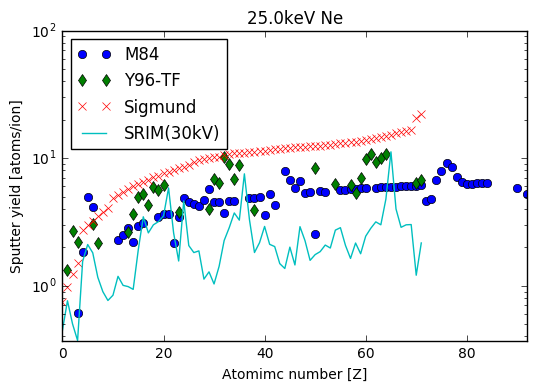

In [267]:
plt.figure(1)
plt.clf()
plt.cla()
plt.hold("on")
y=[]
y2=[]
y3=[]
y4=[]
y5=[]
for i in range(len(Atoms[0])):
    if Atoms[3][i] != 0:
        if Atoms[4][i] != 0:
            y.append(yE(str(Projectile),Atoms[0][i],Energy,"M84","TF"))
            y2.append(yE(str(Projectile),Atoms[0][i],Energy,"Y96","TF"))
            #y3.append(yE(str(Projectile),Atoms[0][i],Energy,"Y96","KrC"))
            y4.append(yE(str(Projectile),Atoms[0][i],Energy,"Sigmund","TF"))
            if Projectile=="He":
                y5.append(Y_He_srim[1][i])
            else:
                y5.append(Y_Ne_srim[1][i])
plt.semilogy(x,y,'o',label='M84')
plt.semilogy(y2,'d',label='Y96-TF')
plt.semilogy(y4,'x',label='Sigmund')
plt.semilogy(y5,label='SRIM(30kV)')
#plt.legend('M84','Y96-TF',"Sigmund","SRIM(30kV)")
plt.legend(loc='upper left')
plt.hold('off')
plt.axis('tight')
plt.ylim([0,100])
plt.title(str(Energy/1000)+"keV "+Projectile)
plt.xlabel('Atomimc number [Z]')
plt.ylabel('Sputter yield [atoms/ion]')
plt.show()
filename="YE_"+Projectile+"_"+str(Energy)+".pdf"
#plt.savefig(filename)



Make a new figure for the energy dependent plots

In [268]:
Energien=[30,100,300,600,1000,3000,6000,10000,15000,20000,25000,30000,40000]

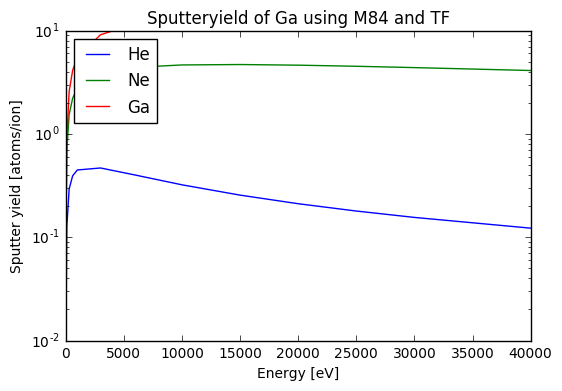

In [269]:
plt.figure(2)
plt.clf()
plt.cla()
plt.hold('on')
j=0
for c in range(len(Ion)):
    y=[]
    for j in range(len(Energien)):
        y.append(yE(Ion[c],Target,Energien[j],sputter,model))
    plt.semilogy(Energien,y,'-',label=Ion[c],nonposy='mask')
plt.legend(loc='upper left')
text="Sputteryield of "+Target+" using "+sputter+" and "+model
plt.title(text)
plt.xlabel('Energy [eV]')
plt.ylabel('Sputter yield [atoms/ion]')
plt.ylim([0.01,10]) # limit the range from 0.01 to 10
plt.show
filename="YE_"+Target+"_"+sputter+"_"+model+".pdf"
#plt.savefig(filename)

Write data to a file so we can use it in other programs

In [270]:
import pandas as pd
import numpy as np

# This is an ugly work around to convert the (needed) array data to pandas dataframes
# Z is going to be the index


In [271]:
y=[]
y1=[]
y2=[]
y3=[]
z=[]
Names=[]
for i in range(len(Atoms[0])):
    if Atoms[3][i] != 0:
        if Atoms[4][i] != 0:
            y.append(yE('He',Atoms[0][i],30000,"M84","TF"))
            y1.append(yE('Ne',Atoms[0][i],30000,"M84","TF"))
            y2.append(yE('Ga',Atoms[0][i],20000,"M84","TF"))
            y3.append(yE('Ar',Atoms[0][i],1000,"M84","TF"))
            z.append(Atoms[1][i])
            Names.append(Atoms[0][i])
temp=pd.DataFrame.from_items([('Name',Names),('Z',z),('He-30',y),('Ne-30',y1),('Ga-20',y2),('Ar-1',y3)])
Elements=temp.set_index('Z')

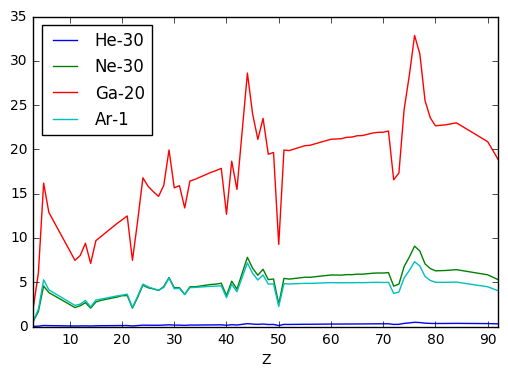

In [272]:
Elements.plot()

In [273]:
# Turn this on when you need the data
#Elements.to_csv('Sputteryields.csv')